In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision
import itertools

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [4]:
import data
import models
import paths
import routine
import viz_tools

In [5]:
import sys
sys.path.append('./dlow/')
from dlow import networks

# Data

LA5 absmax before normalization: 435.2967834472656
Dataset size: 175
Labels distribution: (array([0, 1]), array([125,  50]))

Example:
Image shape: (1, 153, 189, 163)
Target: 0


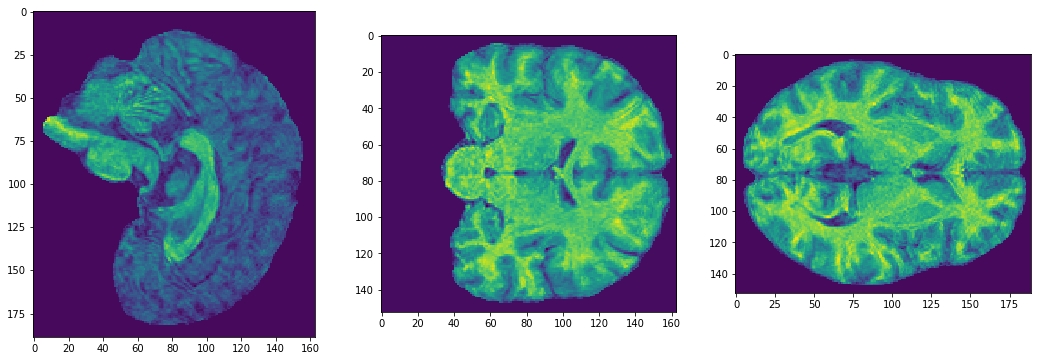

In [6]:
la5_dataset = data.LA5_Siblings_MRI(
    paths=paths.la5_data,
    target_path=paths.la5_target_path,
    load_online=True,
    mri_type="sMRI",
    mri_file_suffix=paths.la5_smri_file_suffix,
    brain_mask_suffix=paths.la5_smri_brain_mask_suffix,
    coord_min=(20,20,0),
    img_shape=(153, 189, 163),
    problems=['Schz/Control'],
    temp_storage_path=paths.la5_temp_npy_folder_path
)
la5_absmax = 435.2967834472656 # data.get_absmax(la5_dataset, device)
la5_dataset.transform = functools.partial(data.AbsMaxScale, absmax=la5_absmax)
print("LA5 absmax before normalization: {}".format(la5_absmax))
print("Dataset size: {}".format(len(la5_dataset)))
print("Labels distribution: {}\n".format(np.unique(la5_dataset.labels, return_counts=True)))

print("Example:")
img, target = la5_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img)

Siblings absmax before normalization: 730.7531127929688
Dataset size: 64
Labels distribution: (array([0, 1]), array([41, 23]))

Example:
Image shape: (1, 153, 189, 163)
Target: 1


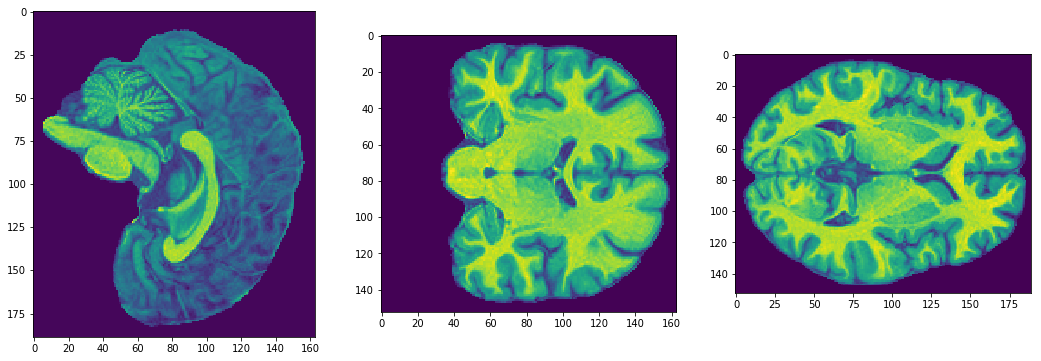

In [7]:
sibl_dataset = data.LA5_Siblings_MRI(
    paths=paths.sibl_data,
    target_path=paths.sibl_target_path,
    load_online=True,
    mri_type="sMRI",
    mri_file_suffix=paths.sibl_smri_file_suffix,
    brain_mask_suffix=paths.sibl_smri_brain_mask_suffix,
    coord_min=(20,20,0),
    img_shape=(153, 189, 163),
    problems=['Schz/Control'],
    temp_storage_path=paths.sibl_temp_npy_folder_path,
)
sibl_absmax = 730.7531127929688 # data.get_absmax(sibl_dataset, device)
sibl_dataset.transform = functools.partial(data.AbsMaxScale, absmax=sibl_absmax)
print("Siblings absmax before normalization: {}".format(sibl_absmax))
print("Dataset size: {}".format(len(sibl_dataset)))
print("Labels distribution: {}\n".format(np.unique(sibl_dataset.labels, return_counts=True)))

print("Example:")
img, target = sibl_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img)

In [8]:
class DLOW(object):
    """Domain Flow for Adaptation and Generalization"""
    def __init__(self):
        gpu_ids = [0]
        self.netZ_2_LAT = networks.define_Z_2_LAT(1, 16, gpu_ids)
        self.netG_A_B = networks.define_stochastic_G(nlatent=16, input_nc=1, output_nc=1, ngf=16, which_model_netG='resnet',
                                                     norm='instance', use_dropout=False, gpu_ids=gpu_ids)
        self.netG_B_A = networks.define_stochastic_G(nlatent=16, input_nc=1, output_nc=1, ngf=16, which_model_netG='resnet',
                                                     norm='instance', use_dropout=False, gpu_ids=gpu_ids)

    def predict_A(self, real_B, z):
        z_lat = self.netZ_2_LAT.forward(z.view(1,1,1,1))
        return self.netG_B_A.forward(real_B, z_lat)

    def predict_B(self, real_A, z):
        z_lat = self.netZ_2_LAT.forward(z.view(1,1,1,1))
        return self.netG_A_B.forward(real_A, z_lat)

    def load(self, chk_path, device):
        checkpoint = torch.load(chk_path, map_location=device)
        self.netZ_2_LAT.load_state_dict(checkpoint['netZ_2_LAT'])
        self.netG_A_B.load_state_dict(checkpoint['netG_A_B'])
        self.netG_B_A.load_state_dict(checkpoint['netG_B_A'])

    def eval(self):
        self.netZ_2_LAT.eval()
        self.netG_A_B.eval()
        self.netG_B_A.eval()

    def train(self):
        self.netZ_2_LAT.train()
        self.netG_A_B.train()
        self.netG_B_A.train()

In [9]:
dlow = DLOW()
dlow.load('./models/dlow4', device)
dlow.eval()

In [10]:
def get_fake(img, z, img_shape=(153, 189), gan_img_shape=(200, 200), fake_domain='A'):
    global dlow
    pad_size = (max(0,gan_img_shape[1]-img_shape[1]), 0,
                max(0, gan_img_shape[0]-img_shape[0]), 0,
                0, 0)
    padder = torch.nn.ConstantPad3d(pad_size, 0)
    # pad
    img_paded = padder(data.ToTensor(np.moveaxis(img, -1, 0))).to(device)
    # transfer
    img_transfered = []
    step = 50
    z_ = torch.FloatTensor([z]).to(device)
    for i in range(0,img.shape[-1],step):
        if fake_domain=='A':
            img_transfered_part = dlow.predict_A(img_paded[i:i+step], z_).detach().cpu().numpy()
        else:
            img_transfered_part = dlow.predict_B(img_paded[i:i+step], z_).detach().cpu().numpy()
        img_transfered.append(img_transfered_part)
        del img_transfered_part
    img_transfered = np.moveaxis(np.concatenate(img_transfered), 0, -1)
    # unpad
    img_transfered = img_transfered[:, pad_size[2]:, pad_size[0]:, :]
    return img_transfered

# DLOW visual results example

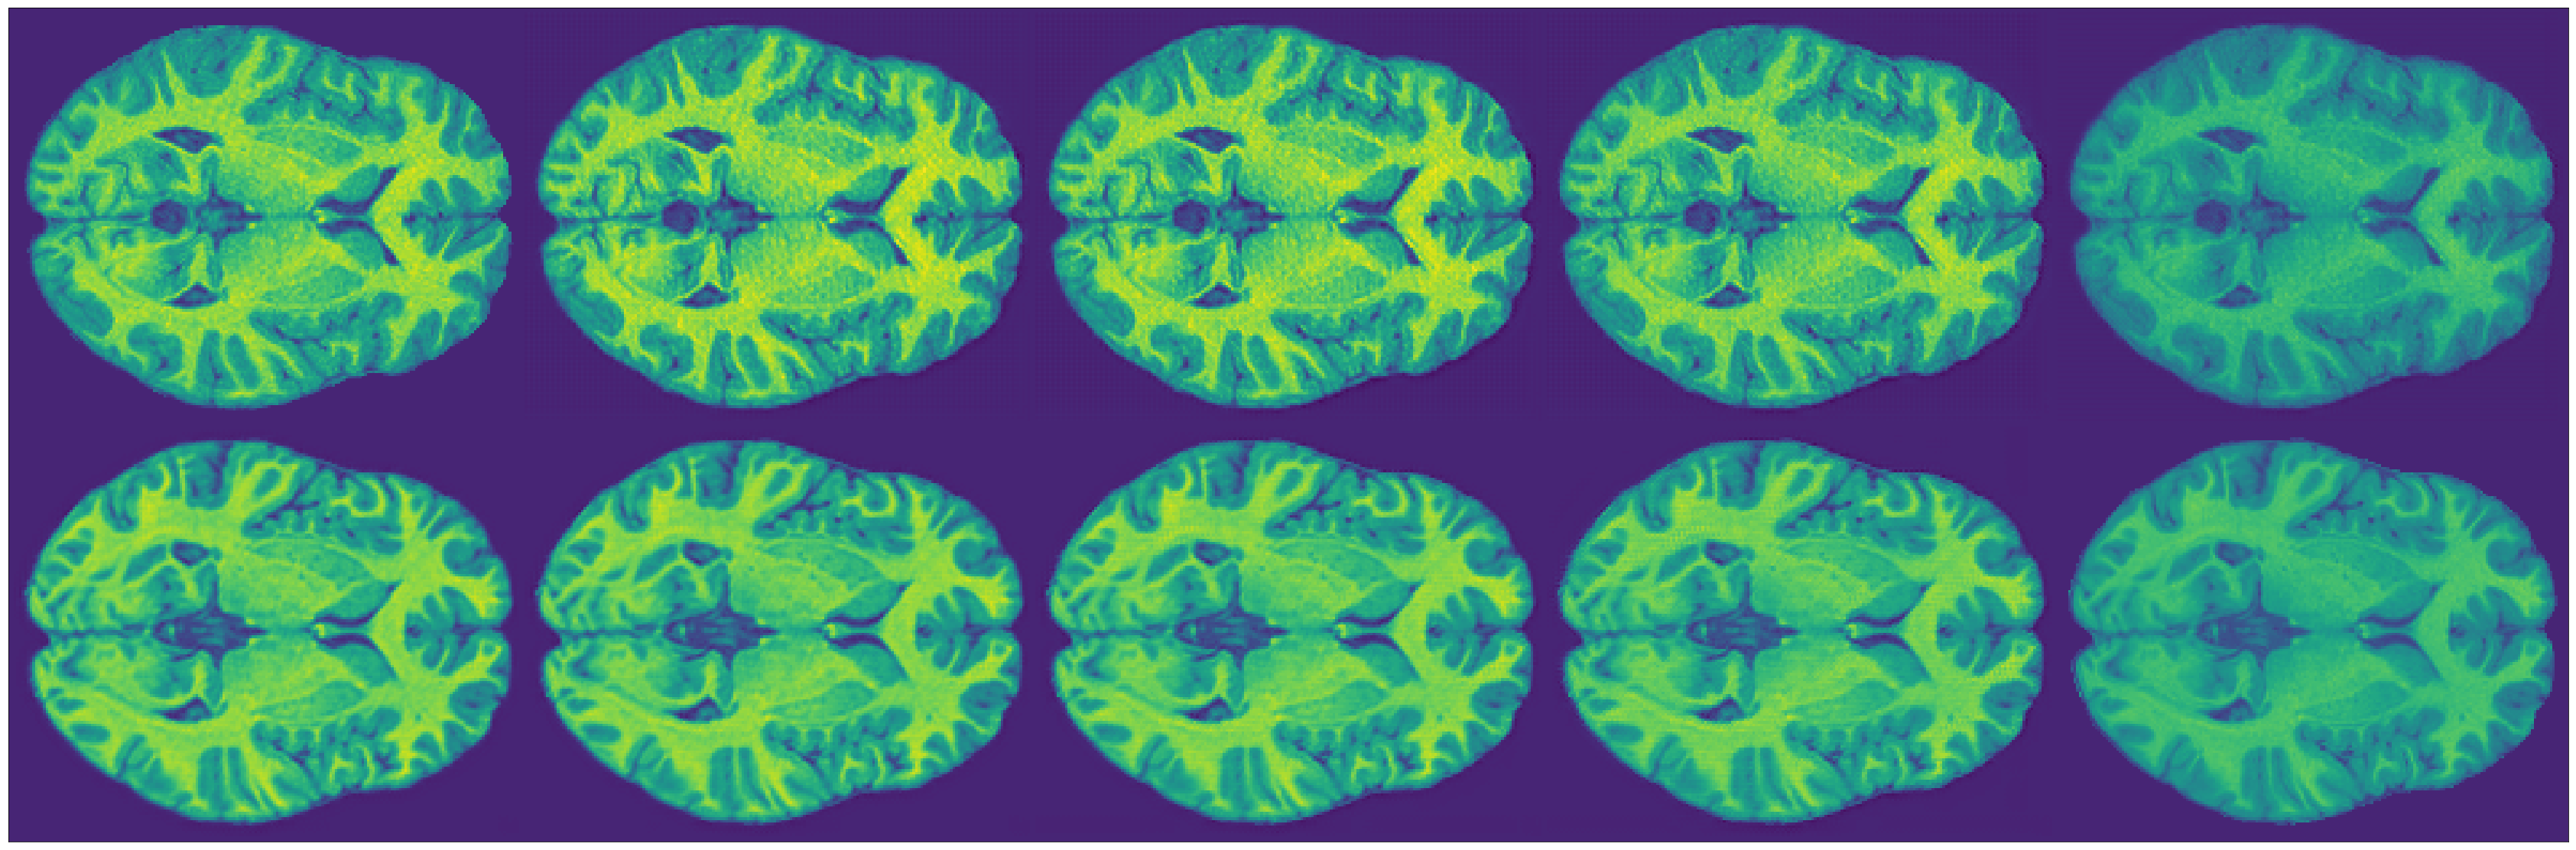

In [11]:
zs = [0., 0.25, 0.5, 0.75, 1.]

img, _ = la5_dataset[-1]
fakes_B = []

for z in zs:
    if z == 0:
        fake = img[0, :, :, 163//2]
    else:
        fake = get_fake(img, z, fake_domain='B')[0, :, :, 163//2]
    fakes_B.append(fake)
fakes_B = np.stack(fakes_B)

img, _ = sibl_dataset[-1]
fakes_A = []
for z in zs:
    if z == 1:
        fake = img[0, :, :, 163//2]
    else:
        fake = get_fake(img, 1-z, fake_domain='A')[0, :, :, 163//2]
    fakes_A.append(fake)
fakes_A = np.stack(fakes_A)

fakes = np.concatenate([fakes_B, fakes_A])
grid = torchvision.utils.make_grid(data.ToTensor(fakes).unsqueeze(1), nrow=len(zs)).permute(1, 2, 0)[:,:,0]
plt.figure(figsize=(30 * 2, 30 * 189//153 * len(zs)))
plt.imshow(torchvision.utils.make_grid(data.ToTensor(fakes).unsqueeze(1), nrow=len(zs)).permute(1, 2, 0)[:,:,0])
plt.xticks(())
plt.yticks(())
plt.show()

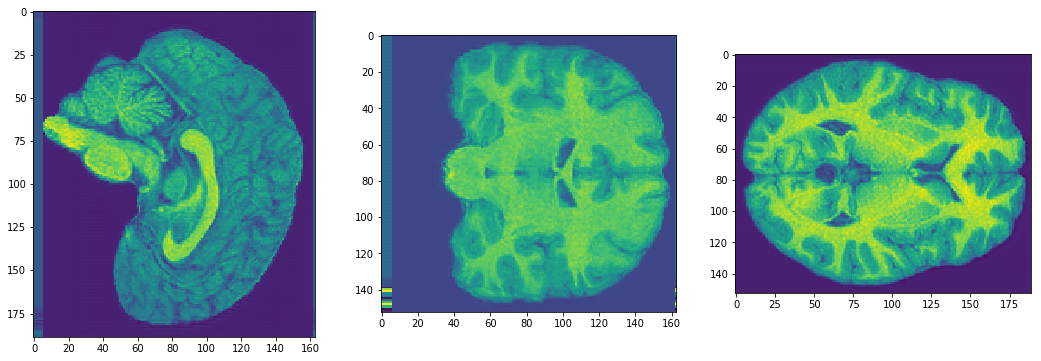

In [12]:
viz_tools.plot_central_cuts(get_fake(la5_dataset[-1][0], 1., fake_domain='B'))

In [13]:
# plt.figure(figsize=(30 * 2, 30 * 189//153 * len(zs)))
# plt.imshow(grid)
# plt.xticks(zs)
# plt.yticks(('A->B', 'B->A'))
# plt.show()

# DLOW(z=1)=CycleGAN

Siblings2LA5 absmax before normalization: 730.7531127929688
Dataset size: 64
Labels distribution: (array([0, 1]), array([41, 23]))

Example:
Image shape: (1, 153, 189, 163)
Target: 1


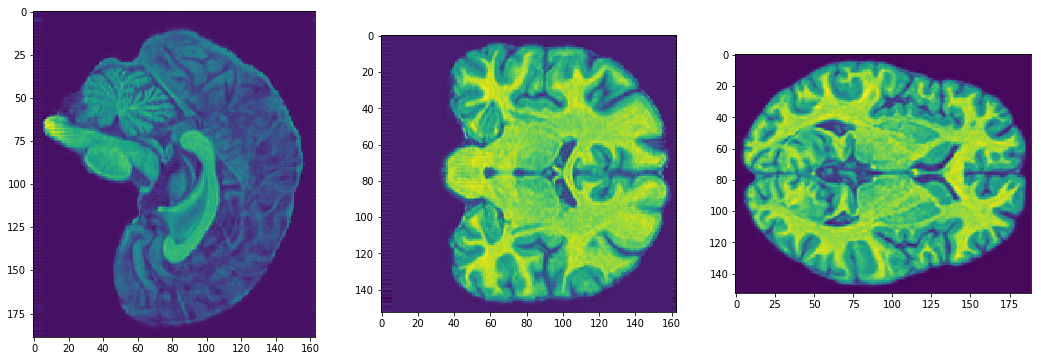

In [14]:
sibl2la5_dataset = data.LA5_Siblings_MRI(
    paths=paths.sibl_data,
    target_path=paths.sibl_target_path,
    load_online=True,
    mri_type="sMRI",
    mri_file_suffix=paths.sibl_smri_file_suffix,
    brain_mask_suffix=paths.sibl_smri_brain_mask_suffix,
    coord_min=(20,20,0),
    img_shape=(153, 189, 163),
    problems=['Schz/Control'],
    temp_storage_path=paths.sibl_temp_npy_folder_path,
)
sibl2la5_dataset.transform = torchvision.transforms.Compose([
    functools.partial(data.AbsMaxScale, absmax=sibl_absmax),
    functools.partial(get_fake, z=1, fake_domain='A'),
])
print("Siblings2LA5 absmax before normalization: {}".format(sibl_absmax))
print("Dataset size: {}".format(len(sibl2la5_dataset)))
print("Labels distribution: {}\n".format(np.unique(sibl2la5_dataset.labels, return_counts=True)))

print("Example:")
img, target = sibl2la5_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img)

Siblings2LA5 absmax before normalization: 730.7531127929688
Dataset size: 175
Labels distribution: (array([0, 1]), array([125,  50]))

Example:
Image shape: (1, 153, 189, 163)
Target: 0


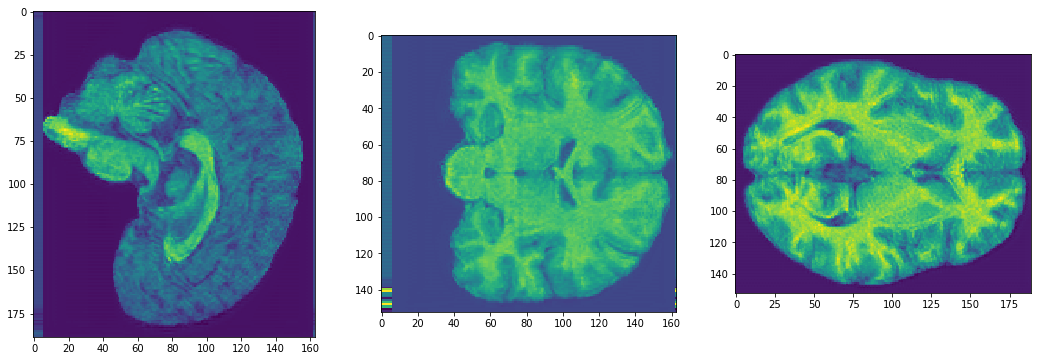

In [15]:
la52sibl_dataset = data.LA5_Siblings_MRI(
    paths=paths.la5_data,
    target_path=paths.la5_target_path,
    load_online=True,
    mri_type="sMRI",
    mri_file_suffix=paths.la5_smri_file_suffix,
    brain_mask_suffix=paths.la5_smri_brain_mask_suffix,
    coord_min=(20,20,0),
    img_shape=(153, 189, 163),
    problems=['Schz/Control'],
    temp_storage_path=paths.la5_temp_npy_folder_path
)
la52sibl_dataset.transform = torchvision.transforms.Compose([
    functools.partial(data.AbsMaxScale, absmax=la5_absmax),
    functools.partial(get_fake, z=1, fake_domain='B'),
])
print("Siblings2LA5 absmax before normalization: {}".format(sibl_absmax))
print("Dataset size: {}".format(len(la52sibl_dataset)))
print("Labels distribution: {}\n".format(np.unique(la52sibl_dataset.labels, return_counts=True)))

print("Example:")
img, target = la52sibl_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img)

In [16]:
def create_model_opt(model_load_path=None, transfer=False):
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = models.VoxResNet(num_classes=2, n_filters=32, stride=2, n_blocks=4,
                             input_shape=la5_dataset.img_shape, dropout=0., n_fc_units=128,
                             n_flatten_units=23040)
    
    if model_load_path is not None:
        model.load_state_dict(torch.load(model_load_path))  
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
        
        last = torch.nn.Linear(128, 2)
        modules = list(list(model.children())[0].children())[:-1] + [last]
        model = torch.nn.Sequential(torch.nn.Sequential(*modules))
        
        opt = torch.optim.Adam(last.parameters(), lr=3e-5)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=3e-5)
    return model, opt

In [17]:
model_save_path = "./models/conv_pretrained_la5.pth"

# Transfer Siblings to LA5 and test 

In [18]:
%%time
la52sibl_dataset.transform = torchvision.transforms.Compose([
    functools.partial(data.AbsMaxScale, absmax=la5_absmax),
    functools.partial(get_fake, z=1, fake_domain='B'),
])

cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, sibl2la5_dataset, cv, device, metric,
                                      model_load_path=model_save_path)

print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

100%|██████████| 2/2 [00:07<00:00,  3.81s/it]

val roc_auc_scores: [0.65]
val roc_auc_score mean: 0.65
val roc_auc_score std: 0.0
CPU times: user 9.01 s, sys: 3.21 s, total: 12.2 s
Wall time: 7.79 s


# Transfer LA5 to siblins, then train and test on combined data

Dataset size: 239
Example:
Image shape: (1, 153, 189, 163)
Target: 0


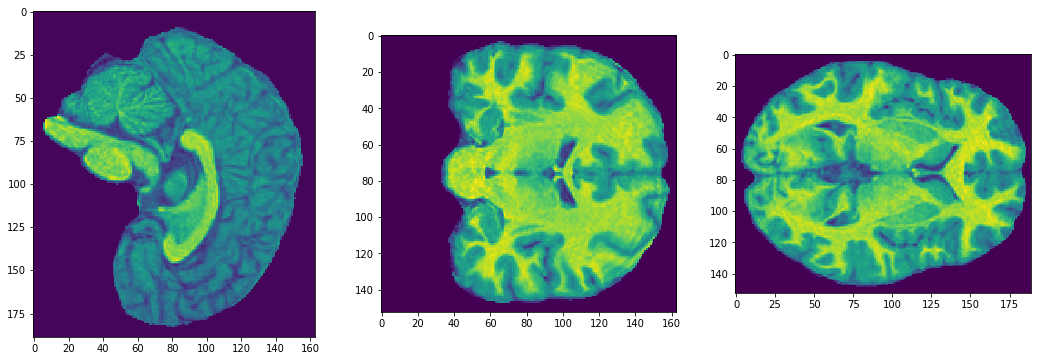

In [19]:
combined_siblings = torch.utils.data.ConcatDataset([sibl_dataset, la52sibl_dataset])
print("Dataset size: {}".format(len(combined_siblings)))

print("Example:")
img, target = combined_siblings[20]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img)

Epoch 9 of 100 took 297.612s
  training loss (in-iteration): 	0.000991
  validation loss: 			1.060940
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.57


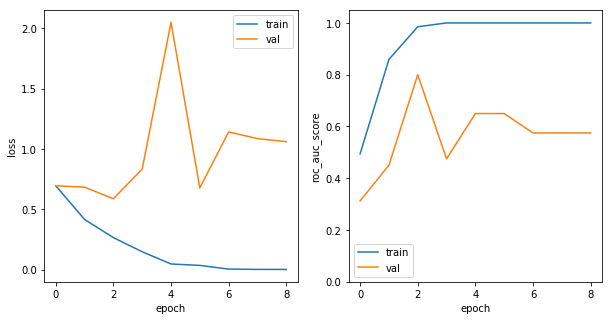

<Figure size 720x360 with 0 Axes>

Early stopping! Train loss < eps.
val roc_auc_scores: [0.575]
val roc_auc_score mean: 0.575
val roc_auc_score std: 0.0


In [20]:
# %%time
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, combined_siblings, cv, device, metric,
                                      eps=1e-3, val_dataset=sibl_dataset,
                                      train_is_augmented=True,
                                      train_pids=np.concatenate([sibl_dataset.pids,la52sibl_dataset.pids]),
                                      train_labels=np.concatenate([sibl_dataset.labels,la52sibl_dataset.labels]),)

print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

# Adaptive Classification

In [21]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from scipy import stats
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

def criterion_GAN(pred, target_is_real):
    if target_is_real:
        target_var = Variable(pred.data.new(pred.size()).long().fill_(1.)) # real = 1
    else:
        target_var = Variable(pred.data.new(pred.size()).long().fill_(0.)) # fake = 0

    loss = F.binary_cross_entropy(pred, target_var)

    return loss

def discriminate(net, crit, fake, real):
    pred_fake = net(fake)
    loss_fake = crit(pred_fake, False)

    pred_true = net(real)
    loss_true = crit(pred_true, True)

    return loss_fake, loss_true, pred_fake, pred_true

def run_one_epoch(model, discriminator, loader, train, device, optimizer=None):
    model.to(device)
    model.train(train)
    discriminator.to(device)
    discriminator.train(train)

    losses = []
    probs = []
    targets = []
    clf_criterion = nn.CrossEntropyLoss()
    
    
#     if train and optimizer is not None:
#         augmentations_loader = DataLoader(la52sibl_dataset, shuffle=True, batch_size=2)
#     else:
#         augmentations_loader = DataLoader(Subset(la52sibl_dataset, np.arange(2)), shuffle=False, batch_size=2)
        
    
    for data_, target in tqdm(loader):
        data_ = data_.to(device, dtype=torch.float)
        fc_real, outputs = model(data_)
        probs.extend(F.softmax(outputs, dim=-1).cpu().data.numpy()[:, 1])
        targets.extend(list(target.cpu().data.numpy()))
        del outputs
        
        z = np.random.rand()
        la52sibl_dataset.transform = torchvision.transforms.Compose([
            functools.partial(data.AbsMaxScale, absmax=la5_absmax),
            functools.partial(get_fake, z=z, fake_domain='B'),])
        if train and optimizer is not None:
            aug_data, aug_targets = #iter(augmentations_loader).next()
        else:
            
        fc_fake, outputs = model(augmented_data)
        loss_fake, loss_true, _, _ = discriminate(discriminator, criterion_GAN, fc_fake, fc_real)
        loss = clf_criterion(outputs, aug_targets) + (0.5*loss_fake + 0.5*loss_true)*torch.sqrt(1.-z)
        if train and optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data.cpu().numpy())
            
        del data_, fc_real, aug_data, aug_targets, fc_fake, outputs, loss_fake, loss_true, _, loss
    del augmentations_loader

    return losses, probs, targets

def train(
    model, discriminator, optimizer, train_dataloader, val_dataloader, device,
    metric, verbose=0, model_save_path=None, max_epoch=100, eps=1e-3):

    best_metric = 0

    epoch_train_loss, epoch_train_metric = [], []
    epoch_val_loss, epoch_val_metric= [], []

    for epoch in range(max_epoch):
        start_time = time.time()

        # 1. Train
        train_losses, train_probs, train_targets = run_one_epoch(model, discriminator, train_dataloader, True, device, optimizer)

        # 2. Inference
        if val_dataloader is not None:
            with torch.no_grad():
                val_losses, val_probs, val_targets = run_one_epoch(model, discriminator, val_dataloader, False, device)

        # 3. Metrics
        epoch_train_loss.append(np.mean(train_losses))
        epoch_train_metric.append(metric(train_targets, train_probs))
        if val_dataloader is not None:
            epoch_val_loss.append(np.mean(val_losses))
            epoch_val_metric.append(metric(val_targets, val_probs))

        # 4. Print metrics
        if verbose:
            clear_output(True)
            print("Epoch {} of {} took {:.3f}s".format(epoch + 1, max_epoch, time.time() - start_time))
            print("  training loss (in-iteration): \t{:.6f}".format(epoch_train_loss[-1]))
            if val_dataloader is not None:
                print("  validation loss: \t\t\t{:.6f}".format(epoch_val_loss[-1]))
            print("  training {}: \t\t\t{:.2f}".format(metric.__name__, epoch_train_metric[-1]))
            if val_dataloader is not None:
                print("  validation {}: \t\t\t{:.2f}".format(metric.__name__, epoch_val_metric[-1]))    
            
        # 5. Plot metrics
        if verbose:
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            plt.figure(figsize=(10, 5))
            axes[0].plot(epoch_train_loss, label='train')
            if val_dataloader is not None:
                axes[0].plot(epoch_val_loss, label='val')
            axes[0].set_xlabel('epoch')
            axes[0].set_ylabel('loss')
            axes[0].legend()
            axes[1].plot(epoch_train_metric, label='train')
            if val_dataloader is not None:
                axes[1].plot(epoch_val_metric, label='val')
            axes[1].set_ylim([0, 1.05])
            axes[1].set_xlabel('epoch')
            axes[1].set_ylabel(metric.__name__)
            axes[1].legend()
            plt.show()
        
        # 5. Early stopping, best metrics, save model
        if epoch_train_loss[-1] < eps:
            print("Early stopping! Train loss < eps.")
            if model_save_path is not None:
                torch.save(model.state_dict(), model_save_path)
            break

    if val_dataloader is not None:    
        return epoch_train_loss[-1], epoch_train_metric[-1], epoch_val_loss[-1], epoch_val_metric[-1]
    else:
        return epoch_train_loss[-1], epoch_train_metric[-1], None, None


def stratified_batch_indices(indices, labels):
    dominating_label = stats.mode(labels)[0][0]
    idx0 = indices[labels == dominating_label]
    idx1 = indices[labels != dominating_label]
    step = np.ceil(len(idx0) / len(idx1)) + 1
    assert step >= 1.
    result = []
    j0 = 0
    j1 = 0
    for i in range(len(indices)):
        if (i % step == 0 or j0 == len(idx0)) and j1 < len(idx1):
            result.append(idx1[j1])
            j1 += 1
        else:
            result.append(idx0[j0])
            j0 += 1
    result = np.array(result)
    assert len(result) == len(indices)
    return result


def cross_val_score(
        create_model_discrim_opt, train_dataset, cv, device, metric, model_load_path=None,
        batch_size=10, val_dataset=None, transfer=False, finetune=False, eps=1e-3):
    assert not (transfer and finetune)
    assert (transfer == False) or (transfer == True and model_load_path is not None)

    val_dataset = train_dataset

    cv_splits = list(cv.split(X=np.arange(len(train_dataset)), y=train_dataset.labels))
    val_metrics = []

    for i in range(len(cv_splits)):
        train_idx, val_idx = cv_splits[i]

        # train data
        if model_load_path is None or transfer or finetune:
            train_idx = stratified_batch_indices(train_idx, train_dataset.labels[train_idx])
            train_loader = DataLoader(Subset(train_dataset, train_idx),
                                      shuffle=False,
                                      batch_size=batch_size,
                                      drop_last=False)

        # val data
        val_mask = (np.isin(val_dataset.pids, train_dataset.pids[train_idx]) == False)
        val_idx = np.arange(len(val_dataset))[val_mask]
        del val_mask
        
        val_loader = DataLoader(Subset(val_dataset, val_idx),
                                shuffle=False,
                                batch_size=batch_size,
                                drop_last=False)
        model, discriminator, optimizer = create_model_discrim_opt()
        _, _, _, last_val_metric = train(model, discriminator, optimizer, train_loader, val_loader, device,
                                         metric=metric, verbose=1, eps=eps)
        val_metrics.append(last_val_metric)
        del train_loader, val_loader, model, optimizer

    return val_metrics

SyntaxError: invalid syntax (<ipython-input-21-b456dac4eeaf>, line 62)

In [ ]:
def create_model_discrim_opt():
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = models.VoxResNetWithFeatures(
        num_classes=2, n_filters=32, stride=2, n_blocks=4,
        input_shape=la5_dataset.img_shape, dropout=0., n_fc_units=128,
        n_flatten_units=23040)
    discriminator = nn.Sequential(nn.Linear(128,64),nn.LeakyReLU(0.2, True),nn.Linear(64,32),nn.LeakyReLU(0.2, True),nn.Linear(32,1),nn.Sigmoid())
    
    opt = torch.optim.Adam(itertools.chain(model.parameters(), discriminator.parameters()), lr=3e-5)
    return model, discriminator, opt

In [ ]:
%%time
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
metric = roc_auc_score
val_metrics = cross_val_score(create_model_discrim_opt, sibl_dataset, cv, device, metric, eps=1e-3)

print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))